# **Fastai và Neptune**
> Neptune là ML platform được sử dụng để track các thông tin của model, giúp chúng ta có thể lưu lại thông số của nhiều phép thử khác nhau, so sánh kết quả, đánh giá model và lựa chọn model phù hợp nhất. Tương đồng với trải nghiệm cùng Weights & Biases, chúng ta cũng sẽ cùng đi qua các models sử dụng fastai với neptune.
>
> Chúng ta sẽ thử nghiệm với các model đã được sử dụng trong repository: [swift_swallow_classification](https://github.com/ddpham/swift_swallow_classification)

**Lưu ý:**
Do neptune có thay đổi về API và fastai callback cho neptune chưa cập nhật với API mới nên khi chạy mà sử dụng NeptuneCallback của fastai sẽ bị lỗi. Chúng ta sẽ sử dụng NeptuneCallback của neptune cho fastai từ module integrations.

In [ ]:
from fastai.vision.all import *
# from fastai.callback.neptune import NeptuneCallback # Không sử dụng NeptuneCallback của fastai
from fastai.metrics import F1Score
import os
import neptune.new as neptune
from neptune.new.integrations.fastai import NeptuneCallback

In [ ]:
# Kiểm tra GPU:
torch.cuda.current_device()

0

# Tạo dữ liệu

In [ ]:
# Khai báo tên user và project:
PROJECT_NAME = 'swift-swallow-classification'
WORKSPACE = 'ddpham'

In [ ]:
# Tạo path:
path = Path('../data/train/')
path.ls()

(#2) [Path('../data/train/swift'),Path('../data/train/swallow')]

In [ ]:
# Tạo hàm tạo dữ liệu:
def get_dls(bs=32, size=224):
    '''Hàm khởi tạo datablocks và dataloaders với biến batch_size và size'''
    dblock = DataBlock(
        blocks=(ImageBlock, CategoryBlock)
        , get_items=get_image_files
        , get_y=parent_label
        , item_tfms=Resize(460)
        , batch_tfms=[*aug_transforms(size=size, min_scale=.75), Normalize.from_stats(*imagenet_stats)]
    )
    return dblock.dataloaders(path, bs=bs)

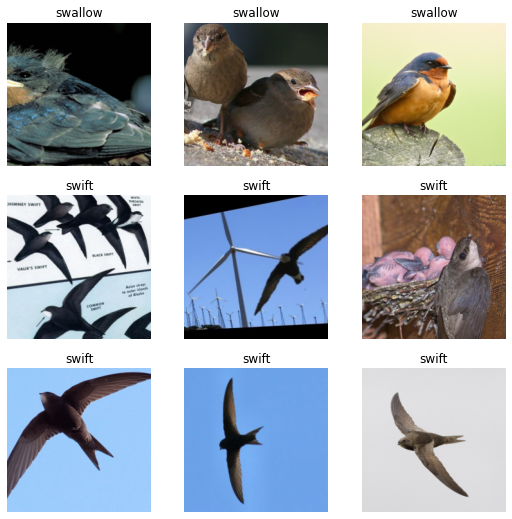

In [ ]:
# Tạo và kiểm tra dữ liệu:
dls = get_dls()
dls.show_batch(max_n=9, ncols=3)

# Base Model

Chúng ta sẽ tạo base model trước khi bắt đầu các bước biến đổi dữ liệu khác nhau để cải thiện model. Chúng ta sẽ sử dụng xresnet50 đã được pretrained làm base model.

## Khởi động neptune
> Trước khi bắt đầu bất kỳ model nào, chúng ta cần phải init project để tạo 1 lần run mới, như vậy, trong project trên neptune, chúng ta sẽ thấy xuất hiện nhiều run khác nhau.
>
> Để bắt đầu neptune, chúng ta sử dụng `neptune.init()`
>
> Để dừng, chúng ta sử dụng `neptune.stop()`

In [ ]:
# Bắt đầu với model mới:
RUN_NAME = 'fastai_base'
RUN_ID = 'PYTORCH-20' # run này đã được khởi tạo từ trước, nếu là run mới, RUN_ID ko cần điền
run = neptune.init(f'{WORKSPACE}/{PROJECT_NAME}', run=RUN_ID, name=RUN_NAME)
# run = neptune.init(f'{WORKSPACE}/{PROJECT_NAME}', name=RUN_NAME)

https://app.neptune.ai/ddpham/swift-swallow-classification/e/PYTORCH-20
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


## Tạo params:
> Khi chạy neptune, chúng ta có thể log chi tiết các paramenters nào mà chúng ta muốn, hoặc assing giá trị cho param để chuyền vào cho model. Các dạng của param (metadata) có thể bao gồm: 
> 1. metrics & losses: chẳng hạn như f1, precision, recall, accuracy...; crossentropy, MAE, RMSE...
> 2. hyperparameters: learning rate 
> 3. figures: lưu lại các đồ thị được sinh ra trong các quá trình
> 4. image predictions: label ảnh thực (y_true) & label ảnh dự báo (y_pred)
> 5. hardware consumption logs: log về các thông số của CPU, GPU, sử dụng disk...
> 6. code snapshots: code bạn chạy để ra được kết quả cuối cùng
> 7. Các thông tin khác bạn cần ghi lại để quản lý.

In [ ]:
# params = {
    
# }

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /home/ddpham/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

/home/ddpham/miniconda3/envs/dl/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


SuggestedLRs(valley=0.0008317637839354575)


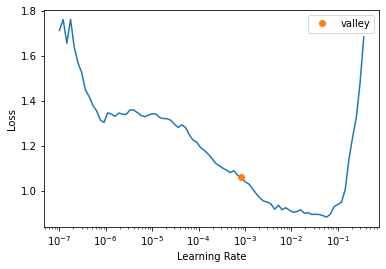

In [ ]:
learn = cnn_learner(dls, resnet50, pretrained=True, 
                    loss_func=CrossEntropyLossFlat(), 
                    metrics=[accuracy, F1Score()],
                   )

# Tìm lr tốt nhất để học:
# neptune.create_experiment()
lr_valley = learn.lr_find()
print(lr_valley)

In [ ]:
# Chỉ log lại thông tin khi sử dụng 
learn.fit_one_cycle(10, lr_max=lr_valley, cbs=[NeptuneCallback(run)])

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.851478,0.452245,0.809859,0.825806,00:10
1,0.596711,0.380530,0.894366,0.907975,00:09
2,0.460834,0.316734,0.908451,0.922156,00:10
3,0.396493,0.217576,0.894366,0.907975,00:09
4,0.356579,0.268932,0.908451,0.923077,00:14
5,0.303196,0.172261,0.950704,0.957576,00:10
6,0.253410,0.228154,0.950704,0.958580,00:11
7,0.201823,0.199365,0.936620,0.947368,00:10
8,0.171232,0.190643,0.936620,0.947368,00:11
9,0.153266,0.196845,0.922535,0.935673,00:09


In [ ]:
# Dừng run:
run.stop()

Shutting down background jobs, please wait a moment...
Done!


Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.


All 1 operations synced, thanks for waiting!


__NOTE:__
Chúng ta có thể dừng wandb ở đây để ghi tiếp model khác.

# Progressive Resize

> Progressive resize (tăng kích cỡ ảnh dần dần) là phương pháp được sử dụng trong DL cho hình ảnh khá phổ biến, trong đó, ảnh sẽ được tăng kích cỡ (size) theo nhiều lần train. Với size ảnh nhỏ, model sẽ học nhanh hơn, còn size lớn hơn, model sẽ được chính xác hơn.

Chúng ta sẽ áp dụng chiến thuật này với 3 kích cỡ khác nhau: 128, 224, 256.
Với `progressive resize`, chúng ta sẽ để callback vào learner để có thể chạy toàn bộ quá trình (bao gồm cả `lr_find`), còn nếu chúng ta chỉ muốn track lại phần fit thì sẽ phải để callback ở phần `fit_one_cycle` (như cách chúng ta làm dưới đây)

In [ ]:
RUN_NAME = 'fastai_PR1'
# RUN_ID = 'PYTORCH-22' # run này đã được khởi tạo từ trước, nếu là run mới, RUN_ID ko cần điền
# run = neptune.init(f'{WORKSPACE}/{PROJECT_NAME}', run=RUN_ID, name=RUN_NAME)
run = neptune.init(f'{WORKSPACE}/{PROJECT_NAME}', name=RUN_NAME)

https://app.neptune.ai/ddpham/swift-swallow-classification/e/PYTORCH-22
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


## Size = 128

In [ ]:
## Bắt đầu vs 128:
dls = get_dls(128, 128) # bs=128, size=128
learn = cnn_learner(dls, resnet50, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, F1Score()])

SuggestedLRs(valley=0.0005754399462603033)


epoch,train_loss,valid_loss,accuracy,f1_score,time
0,1.014757,0.809111,0.725352,0.723404,00:09
1,0.831910,0.399758,0.873239,0.891566,00:08
2,0.716630,0.485403,0.838028,0.855346,00:09
3,0.621839,0.419425,0.859155,0.876543,00:08
4,0.549093,0.376522,0.866197,0.883436,00:08


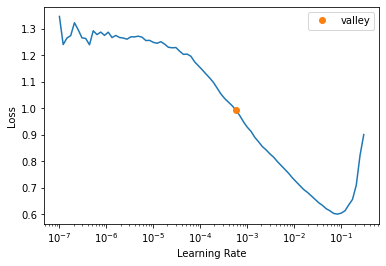

In [ ]:
lr_valley = learn.lr_find()
print(lr_valley)
learn.fit_one_cycle(5, lr_max=lr_valley, cbs=[NeptuneCallback(run)])

__NOTE:__
chúng ta có thể thấy vói size=128, kết quả trả về cho accuracy và F1score thấp hơn so với size=224 của base model ở trên. Chúng ta sẽ tiếp tục thử nghiệm với size lớn hơn.

## Size = 224

SuggestedLRs(valley=0.0010000000474974513)


epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.552444,0.118636,0.964789,0.969697,00:10
1,0.415589,0.217419,0.922535,0.933333,00:10
2,0.339522,0.369543,0.901408,0.914634,00:10
3,0.291599,0.407390,0.901408,0.913580,00:10
4,0.264211,0.288361,0.929577,0.939024,00:10
5,0.225013,0.333924,0.929577,0.939024,00:09
6,0.198380,0.257328,0.929577,0.939759,00:09
7,0.171264,0.240900,0.929577,0.939759,00:09
8,0.156041,0.243640,0.936620,0.945455,00:09
9,0.133598,0.241569,0.936620,0.945455,00:10


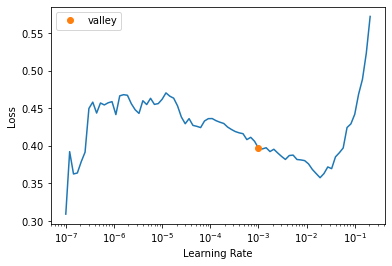

In [ ]:
## Update size của dữ liệu
learn.dls = get_dls(64, 224) # bs=64, size=224
lr_valley = learn.lr_find()
print(lr_valley)
learn.fit_one_cycle(10, lr_max=lr_valley, cbs=[NeptuneCallback(run)])

__NOTE:__ 
Trong quá trình train, chúng ta lưu ý tránh để lỗi typo trong code, có thể ảnh hưởng đến kết quả train! Vì kết quả của chúng ta là dạng lũy kế nên các lỗi sai không đáng có (lr_find, fit_one_cycle) có thể ảnh hưởng đến weights của model.

## Size = 256

SuggestedLRs(valley=0.0002754228771664202)


epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.130216,0.079839,0.978873,0.982036,00:16
1,0.118973,0.079836,0.978873,0.982036,00:11
2,0.119352,0.089455,0.971831,0.976190,00:10
3,0.141556,0.106828,0.957747,0.964706,00:10
4,0.145457,0.127794,0.964789,0.970414,00:10
5,0.125323,0.142167,0.964789,0.970414,00:10
6,0.118029,0.121106,0.971831,0.976190,00:10
7,0.098857,0.126281,0.964789,0.970414,00:10
8,0.085932,0.130098,0.964789,0.970414,00:10
9,0.068963,0.118342,0.964789,0.970414,00:10


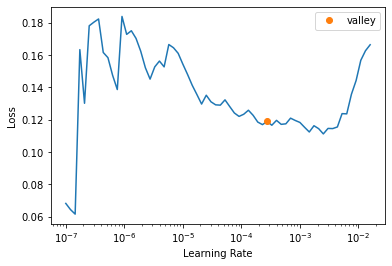

In [ ]:
## Update size của dữ liệu
learn.dls = get_dls(32, 256) # bs=32, size=256
lr_valley = learn.lr_find()
print(lr_valley)

# Ở đây chúng ta sẽ bổ sung thêm SaveModelCallback để lưu model tốt nhất:
learn.fit_one_cycle(15, lr_max=lr_valley, cbs=[NeptuneCallback(run), SaveModelCallback(fname=RUN_NAME)])

__NOTE:__
Kết quả của model này tốt hơn rất nhiều so với base model. Hãy dừng wandb lại để thử lại một lần nữa với số lượng epochs khác.

In [ ]:
run.stop()

## Thử lại
> giờ chúng ta sẽ thử lại các bước của PR và thay callback vào model:

In [ ]:
# Khởi động lại neptune:
RUN_NAME = 'fastai_PR2'
# RUN_ID = 'PYTORCH-23' # run này đã được khởi tạo từ trước, nếu là run mới, RUN_ID ko cần điền
# run = neptune.init(f'{WORKSPACE}/{PROJECT_NAME}', run=RUN_ID, name=RUN_NAME)
run = neptune.init(f'{WORKSPACE}/{PROJECT_NAME}', name=RUN_NAME)

https://app.neptune.ai/ddpham/swift-swallow-classification/e/PYTORCH-23
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


Info (NVML): Unknown Error. GPU usage metrics may not be reported. For more information, see https://docs-legacy.neptune.ai/logging-and-managing-experiment-results/logging-experiment-data.html#hardware-consumption 


/home/ddpham/miniconda3/envs/dl/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


SuggestedLRs(valley=0.0005754399462603033)


epoch,train_loss,valid_loss,accuracy,f1_score,time
0,1.063143,1.361585,0.598592,0.521008,00:09
1,0.832100,0.552828,0.866197,0.881988,00:07
2,0.665494,0.340056,0.901408,0.917647,00:07
3,0.593328,0.310148,0.908451,0.923977,00:07


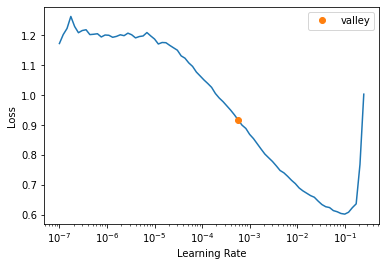

In [ ]:
dls = get_dls(128, 128)
learn = cnn_learner(dls, resnet50, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, F1Score()])
lr_valley = learn.lr_find()
print(lr_valley)
learn.fit_one_cycle(4, lr_max=lr_valley, cbs=[NeptuneCallback(run=run)])

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.417649,0.139001,0.943662,0.952381,00:11
1,0.410978,0.172313,0.929577,0.940476,00:09
2,0.328421,0.134551,0.957747,0.962963,00:10
3,0.289002,0.199085,0.950704,0.957576,00:09
4,0.262368,0.205837,0.943662,0.951807,00:11
5,0.233073,0.201634,0.950704,0.957576,00:11
6,0.199207,0.202846,0.950704,0.957576,00:11
7,0.178204,0.197756,0.950704,0.957576,00:11


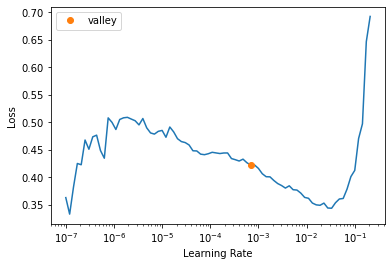

In [ ]:
learn.dls = get_dls(64, 224)
lr_valley = learn.lr_find()
learn.fit_one_cycle(8, lr_max=lr_valley, cbs=[NeptuneCallback(run=run)])

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.250360,0.050511,0.992958,0.994083,00:13
1,0.235278,0.072184,0.978873,0.982249,00:10
2,0.216795,0.136823,0.971831,0.976190,00:11
3,0.186848,0.136516,0.964789,0.970760,00:11
4,0.171614,0.164360,0.957747,0.963855,00:11
5,0.158916,0.098974,0.971831,0.976471,00:11
6,0.130081,0.112583,0.964789,0.970414,00:11
7,0.111278,0.111624,0.971831,0.976471,00:11
8,0.100080,0.099811,0.978873,0.982249,00:11
9,0.086580,0.109655,0.971831,0.976471,00:11


Better model found at epoch 0 with valid_loss value: 0.050510991364717484.


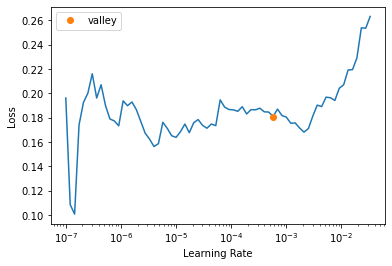

In [ ]:
learn.dls = get_dls(32, 256)
lr_valley = learn.lr_find()
learn.fit_one_cycle(12, lr_max=lr_valley, cbs=[NeptuneCallback(run=run), SaveModelCallback(fname=RUN_NAME)])

__NOTE:__
bạn thấy đó, kết quả thật sự tuyệt vời! Tuy nhiên, chúng ta đã có thể đạt kết quả tốt hơn chỉ với 5 epochs cho size lớn này.
Chúng ta hay lưu lại kết quả này:

In [ ]:
run.stop()

Shutting down background jobs, please wait a moment...
Done!


Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.


All 1 operations synced, thanks for waiting!


# MixUp

> MixUp cũng là một trong nhưng phương pháp sửa ảnh khá thú vị mà chúng ta có thể sử dụng. Ý tưởng của phương pháp này là chúng ta sẽ tạo ra thêm các bức ảnh là sự kết hợp giữa 2 ảnh bất kỳ nào đó với 1 tỷ lệ nhất định, ví dụ 70% chim Yến, 30% chim Yén. Việc này cũng sẽ khiến cho khả năng dự đoán của model sẽ khó hơn. Ngoài ra, kết quả dự đoán cuối cùng sẽ không phải là chim Yến (70%) mà phải là 70% chim Yến, 30% chim Yén. 

Chúng ta hay cùng đi qua ví dụ để hiểu nó hơn:

In [ ]:
# Khởi động lại neptune:
RUN_NAME = 'fastai_mixup'
# RUN_ID = 'PYTORCH-24' # run này đã được khởi tạo từ trước, nếu là run mới, RUN_ID ko cần điền
# run = neptune.init(f'{WORKSPACE}/{PROJECT_NAME}', run=RUN_ID, name=RUN_NAME)
run = neptune.init(f'{WORKSPACE}/{PROJECT_NAME}', name=RUN_NAME)

https://app.neptune.ai/ddpham/swift-swallow-classification/e/PYTORCH-24
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


In [ ]:
from fastai.callback import mixup
mixup_ = mixup.MixUp(alpha=0.3)

In [ ]:
dls = get_dls(32, 224)
model = resnet50(pretrained=True)

SuggestedLRs(valley=0.0014454397605732083)


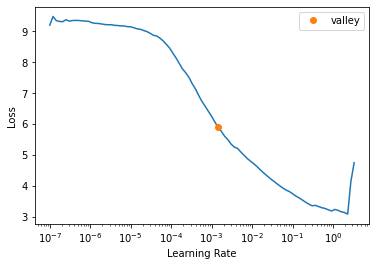

In [ ]:
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, F1Score(average='macro')])
lr_valley = learn.lr_find()
print(lr_valley)

In [ ]:
learn.fit_one_cycle(80, lr_max=lr_valley, cbs=[mixup_, NeptuneCallback(run=run), SaveModelCallback(fname=RUN_NAME)])

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,6.122236,2.408354,0.697183,0.087325,00:12
1,3.860533,1.449207,0.809859,0.272962,00:12
2,2.593692,0.654248,0.915493,0.905585,00:12
3,1.798195,0.633472,0.859155,0.852575,00:13
4,1.315868,0.389893,0.830986,0.824149,00:18
5,1.000018,0.375941,0.852113,0.844712,00:16
6,0.782576,0.285601,0.838028,0.829922,00:24
7,0.624692,0.445761,0.866197,0.833405,00:18
8,0.525234,0.263072,0.887324,0.879584,00:14
9,0.462409,0.280778,0.901408,0.891957,00:13


Better model found at epoch 0 with valid_loss value: 2.408353805541992.
Better model found at epoch 1 with valid_loss value: 1.4492071866989136.
Better model found at epoch 2 with valid_loss value: 0.6542475819587708.
Better model found at epoch 3 with valid_loss value: 0.6334716081619263.
Better model found at epoch 4 with valid_loss value: 0.38989341259002686.
Better model found at epoch 5 with valid_loss value: 0.37594133615493774.
Better model found at epoch 6 with valid_loss value: 0.28560081124305725.
Better model found at epoch 8 with valid_loss value: 0.26307204365730286.
Better model found at epoch 52 with valid_loss value: 0.25833332538604736.
Better model found at epoch 70 with valid_loss value: 0.24232783913612366.


In [ ]:
run.stop()

Shutting down background jobs, please wait a moment...
Done!


Waiting for the remaining 28 operations to synchronize with Neptune. Do not kill this process.
Still waiting for the remaining 28 operations (0.00% done). Please wait.
Still waiting for the remaining 28 operations (0.00% done). Please wait.


All 28 operations synced, thanks for waiting!


# Label Smooth
> Label smooth có sự tương đồng với MixUp. Chúng ta tạo ra dữ liệu được sửa đổi thông qua việc gộp các ảnh với nhau như cách làm của mixup, hoặc có thể sửa label với bằng giá trị tương đối từ 0-1 thay vì chỉ có thể là 0 hoặc 1. Việc này sẽ giúp cho model học tốt hơn thay vì phải cố gắng để học đúng được giá trị tuyệt đối là 1. c

In [ ]:
# Khởi động lại neptune:
RUN_NAME = 'fastai_lbs'
# RUN_ID = 'PYTORCH-25' # run này đã được khởi tạo từ trước, nếu là run mới, RUN_ID ko cần điền
# run = neptune.init(f'{WORKSPACE}/{PROJECT_NAME}', run=RUN_ID, name=RUN_NAME)
run = neptune.init(f'{WORKSPACE}/{PROJECT_NAME}', name=RUN_NAME)

https://app.neptune.ai/ddpham/swift-swallow-classification/e/PYTORCH-25
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


SuggestedLRs(valley=0.0006918309954926372)


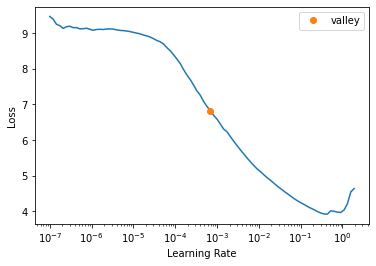

In [ ]:
dls = get_dls(32, 224)
model = resnet50(pretrained=True)
learn = Learner(dls, model, loss_func=LabelSmoothingCrossEntropyFlat(), metrics=[accuracy, F1Score(average='macro')])
lr_valley = learn.lr_find()
print(lr_valley)

In [ ]:
learn.fit_one_cycle(20, lr_max=lr_valley, cbs=[NeptuneCallback(run), SaveModelCallback(fname=RUN_NAME)])

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,6.950513,3.383897,0.683099,0.076910,00:14
1,4.387484,2.182736,0.873239,0.873013,00:13
2,3.065465,3.931546,0.401408,0.154826,00:13
3,2.362729,1.478672,0.809859,0.794346,00:12
4,1.938446,1.236769,0.936620,0.935464,00:12
5,1.675009,1.147576,0.964789,0.964147,00:12
6,1.506235,1.437663,0.845070,0.833120,00:12
7,1.400371,1.260959,0.894366,0.893473,00:13
8,1.307193,1.191591,0.936620,0.934592,00:14
9,1.242005,1.231981,0.943662,0.943257,00:14


Better model found at epoch 0 with valid_loss value: 3.383896827697754.
Better model found at epoch 1 with valid_loss value: 2.1827359199523926.
Better model found at epoch 3 with valid_loss value: 1.4786720275878906.
Better model found at epoch 4 with valid_loss value: 1.2367688417434692.
Better model found at epoch 5 with valid_loss value: 1.1475759744644165.
Better model found at epoch 13 with valid_loss value: 1.1281911134719849.
Better model found at epoch 14 with valid_loss value: 1.1115809679031372.
Better model found at epoch 17 with valid_loss value: 1.109546184539795.


In [ ]:
run.stop()

Shutting down background jobs, please wait a moment...
Done!


Waiting for the remaining 17 operations to synchronize with Neptune. Do not kill this process.
Still waiting for the remaining 17 operations (0.00% done). Please wait.
Still waiting for the remaining 17 operations (0.00% done). Please wait.


All 17 operations synced, thanks for waiting!
